In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
import shutil
import os
import zipfile

root_dir = '/content'
Data_dir = '/content/smile_data'

if os.path.exists(Data_dir):
  shutil.rmtree(Data_dir)

with zipfile.ZipFile(os.path.join(root_dir,'drive/MyDrive/data','smile.zip'),'r') as file:
  file.extractall(root_dir)

shutil.move('/content/smile','/content/smile_data/smile')
shutil.move('/content/non_smile','/content/smile_data/non_smile')

'/content/smile_data/non_smile'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import glob
import pandas as pd

Label = LabelEncoder()
img_size = (224,224)

def img_read(img):
  img = cv2.imread(img,cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img,cv2.BGR2RGB)
  img = cv2.resize(img,img_size)
  return img

dir = os.listdir(Data_dir)

data = []

for d in dir:
  path = os.path.join(Data_dir,d)
  for p in glob.glob(path + '/*.jpg'):
    fp = []
    fp.append(p)
    fp.append(d)
    data.append(fp)

df = pd.DataFrame(data=data,columns = ['file_path','label'])
Label.fit(df['label'])

LabelEncoder()

In [ ]:
img_gen = ImageDataGenerator(rescale = 1/255)
train_gen = ImageDataGenerator(rescale = 1/255,rotation_range=10.0,
                               horizontal_flip=True)

df_train,df_test=   train_test_split(df,test_size=0.3,random_state =47,stratify=df['label'])
df_test,df_val=train_test_split(df_test,test_size=0.5,random_state =47,stratify=df_test['label'])

dft_train = img_gen.flow_from_dataframe(df_train,x_col='file_path',y_col='label',target_size=img_size,
                                       class_mode='binary',batch_size=32,color_mode='rgb')

train_batch = len(df_train)
df_train = train_gen.flow_from_dataframe(df_train,x_col='file_path',y_col='label',target_size=img_size,
                                       class_mode='binary',batch_size=160,color_mode='rgb')

df_test = img_gen.flow_from_dataframe(df_test,x_col='file_path',y_col='label',target_size=img_size,
                                      class_mode='binary',batch_size=32,color_mode='rgb')

df_val = img_gen.flow_from_dataframe(df_val,x_col='file_path',y_col='label',target_size=img_size,
                                     class_mode='binary',batch_size=32,color_mode='rgb')

Found 842 validated image filenames belonging to 2 classes.
Found 842 validated image filenames belonging to 2 classes.
Found 180 validated image filenames belonging to 2 classes.
Found 181 validated image filenames belonging to 2 classes.


In [ ]:
iter = 5

train_img = []
train_label = []
for i in range(iter):
  img,label = df_train.next()
  length = len(img)

  for d in range(length):
    train_img.append(img[d])
    train_label.append(label[d])
  
for i in range((train_batch-1)//32+1):
  img,label = dft_train.next()
  length = len(img)

  for d in range(length):
    train_img.append(img[d])
    train_label.append(label[d])

train_img = tf.reshape(train_img,[-1,224,224,3])
print(train_img.shape)
train_label = tf.reshape(train_label,[-1,1])

(1642, 224, 224, 3)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers

classlen = len(Label.classes_)
base_model = MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='max')

model = Sequential([
    base_model,
    Dense(512,kernel_regularizer=regularizers.L2(1e-5)),BatchNormalization(),Activation('relu'),
    Dense(256,kernel_regularizer=regularizers.L2(1e-5)),BatchNormalization(),Activation('relu'),
    Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=(1e-5)),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
check_path = '/content/checkpoint'
earlystop = EarlyStopping(monitor='val_loss',patience=3)
checkpoint = ModelCheckpoint(check_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

hist = model.fit(train_img,train_label,epochs=30,validation_data = df_val,callbacks=[earlystop,checkpoint])

Epoch 1/30
52/52 [==============================] - 17s 226ms/step - loss: 0.7923 - accuracy: 0.5134 - val_loss: 0.8019 - val_accuracy: 0.4807
Epoch 2/30
52/52 [==============================] - 10s 201ms/step - loss: 0.6082 - accuracy: 0.6724 - val_loss: 0.6704 - val_accuracy: 0.5801
Epoch 3/30
52/52 [==============================] - 10s 201ms/step - loss: 0.5078 - accuracy: 0.7716 - val_loss: 0.5533 - val_accuracy: 0.7403
Epoch 4/30
52/52 [==============================] - 10s 201ms/step - loss: 0.4148 - accuracy: 0.8502 - val_loss: 0.4668 - val_accuracy: 0.8508
Epoch 5/30
52/52 [==============================] - 11s 203ms/step - loss: 0.3513 - accuracy: 0.8983 - val_loss: 0.3975 - val_accuracy: 0.8895
Epoch 6/30
52/52 [==============================] - 10s 198ms/step - loss: 0.2996 - accuracy: 0.9342 - val_loss: 0.3621 - val_accuracy: 0.8785
Epoch 7/30
52/52 [==============================] - 10s 196ms/step - loss: 0.2590 - accuracy: 0.9421 - val_loss: 0.3255 - val_accuracy: 0.8840

In [ ]:
model.load_weights(check_path)

model.evaluate(df_test)

6/6 [==============================] - 1s 105ms/step - loss: 0.1237 - accuracy: 0.9556


[0.12370851635932922, 0.9555555582046509]

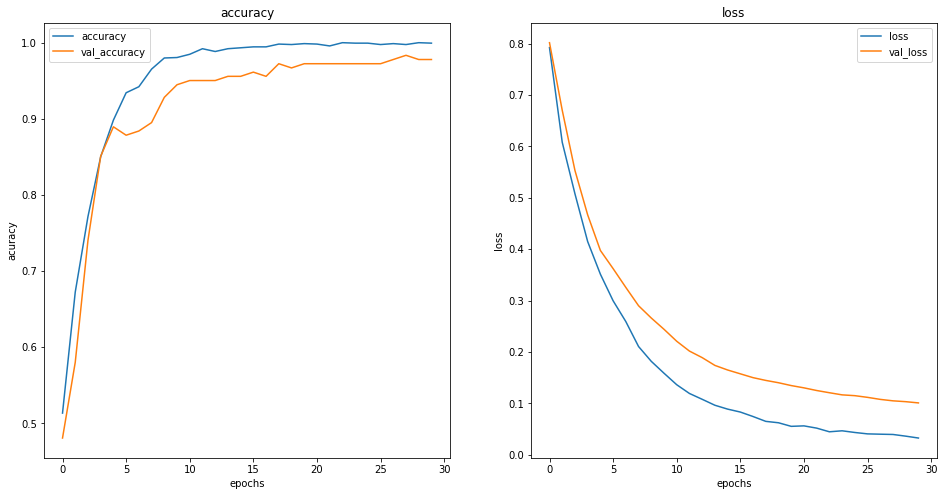

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acuracy')
plt.legend(['accuracy','val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()